# DS 422 Final Project

## Name: Victor Agaba

## Date: 2023-05-12

***

The goal of this project is to compare different solution methods:

Gradient descent vs Grid search

In [4]:
# import required packages
from numpy import *
import matplotlib.pyplot as plt
import seismic_model as sm
import minimize_objective as mo
from obspy.taup import TauPyModel
import function_repo as fr
import importlib
from time import time

ModuleNotFoundError: No module named 'obspy'

Original sdr:  [349.80684364  42.35375567 -18.91855175]


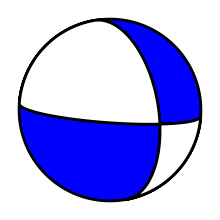

In [795]:
random.seed(422)

# create random array for t, normalised to 1
t = random.rand(3)
t /= linalg.norm(t)

# create random array for p, normalised to 1
direc = random.rand(3)
direc /= linalg.norm(direc)
p = fr.starting_direc(t, direc)

# get sdr for test case
sdr = fr.my_tp2sdr(t, p, True)[0]
print('Original sdr: ', sdr)

# plot corresponding beachball
beachball = fr.beachball(sdr)

In [796]:
# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P', 'S'])
takeoff_angles = [a.takeoff_angle for a in arrivals]
alpha, beta = 5.8000, 3.4600
b3_over_a3 = (beta/alpha)**3
Ao = array(fr.Rpattern(sdr, azimuth, takeoff_angles, [alpha, beta]))

***
#### 1. Gradient descent with backtracking linesearch
***

In [797]:
# initialize with notation from project description
phi = deg2rad(azimuth)
i, j = takeoff_angles
i, j = deg2rad(i), deg2rad(j)
d = Ao

In [798]:
# set up optimization problem
my_model = sm.SeismicModel(phi, i, j, alpha, beta, d)

# initialize options for gradient descent
options = mo.init_options()
options['output_level'] = 2
options['tol'] = 1e-5

# make initial guess
x_start = zeros(3)

# run with the default initial guess (0)
start_time = time()
status, m_sol, E_sol = mo.minimize(my_model, options, x_start=x_start)
end_time = time()
duration = end_time - start_time

Running gradient_descent method with backtracking line search at step size 1

  iter                       f   ||d_k||     alpha  # func   perturb  ||grad||
     0  3.9091012453866791e-01  0.00e+00  0.00e+00       0  0.00e+00  8.84e-01
     1 -6.2237354968843805e-01  8.84e-01  1.00e+00       1  0.00e+00  1.50e+00
     2 -6.4974888337991854e-01  1.50e+00  5.00e-01       2  0.00e+00  1.06e+00
     3 -9.1069304100706194e-01  1.06e+00  5.00e-01       2  0.00e+00  5.58e-01
     4 -9.4855688878812583e-01  5.58e-01  5.00e-01       2  0.00e+00  3.80e-01
     5 -9.6211861994124281e-01  3.80e-01  5.00e-01       2  0.00e+00  4.00e-01
     6 -9.8825891757702478e-01  4.00e-01  2.50e-01       3  0.00e+00  8.20e-02
     7 -9.9851494208857650e-01  8.20e-02  1.00e+00       1  0.00e+00  4.20e-02
     8 -9.9991030619142440e-01  4.20e-02  1.00e+00       1  0.00e+00  2.42e-02
     9 -9.9993123406483031e-01  2.42e-02  2.50e-01       3  0.00e+00  2.30e-02
  iter                       f   ||d_k||     alpha  #

Best sdr:  [-15.10578685  30.50279486 -31.89273433]
Cosine similarity:  0.999999999992527
Duration:  0.01700115203857422


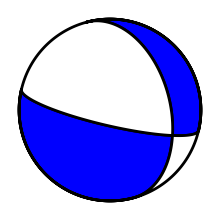

In [799]:
# print results
m_deg = rad2deg(m_sol)
print('Best sdr: ', m_deg)
print('Cosine similarity: ', -E_sol)
print('Duration: ', duration)

# plot corresponding beachball
beachball = fr.beachball(m_deg)

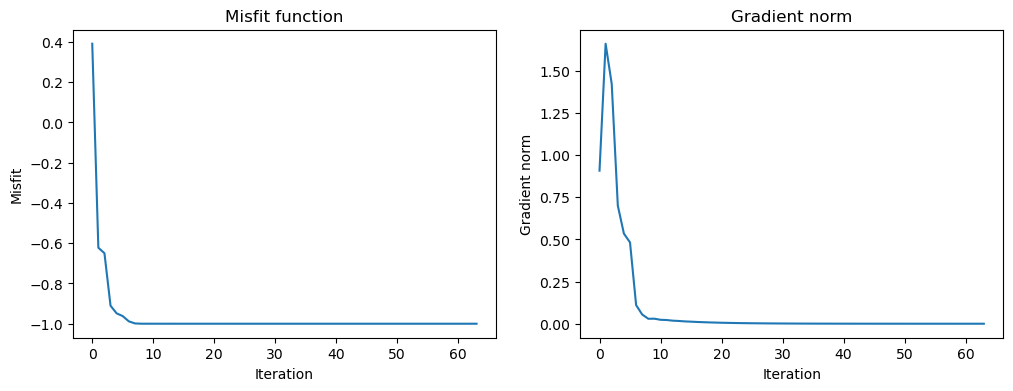

In [800]:
# plot the misfit and gradient norm
my_model.plot_misfit()

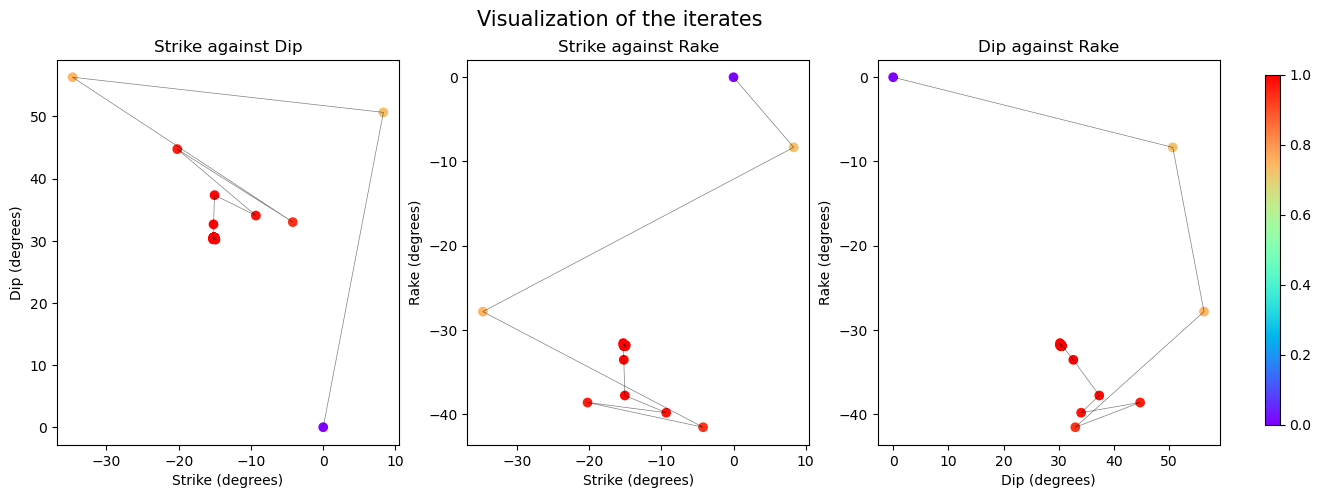

In [801]:
# plot the iterates
importlib.reload(sm)
my_model.plot_iterates()

In [802]:
# compare m_sol with d using R_pattern
g = fr.Rpattern(m_deg, azimuth, takeoff_angles, [alpha, beta])

# get cosine similarity
cossim = fr.cossim(g, d)
if abs(cossim - 1) < 1e-5:
    print('Solution verified!')
else:
    print("Something's not right...")

Solution verified!


***
#### 2. Standard grid search
***

In [803]:
# function definition
def grid_search(dd, Ao, azimuth, takeoff_angles, alpha, beta) -> tuple:
    '''
    Implements grid search as an inversion method.
    '''
    
    # look for sdr that minimizes the misfit function
    best_sdr = zeros(3)
    best_misfit = inf
    
    # grid search in tp space, convert to sdr: equivalent
    Ts = fr.rigid_hemisphere_samples(dd)
    P_rotations = arange(0, pi, deg2rad(dd))
    counter = 0
    for T in Ts:
        P_start = fr.starting_direc(T, fr.i_hat + fr.j_hat + fr.k_hat)
        for theta in P_rotations:
            P = fr.rodrigues_rotate(P_start, T, theta)
            sdr = fr.my_tp2sdr(T, P, True)[0]
            
            # do forward model
            As = fr.Rpattern(sdr, azimuth, takeoff_angles, [alpha, beta])
            
            # look at negative of cosine similarity
            misfit = -fr.cossim(Ao, As)
            
            # update best_sdr if necessary
            if misfit < best_misfit:
                best_sdr = sdr
                best_misfit = misfit
            
            # update counter
            counter += 1
    
    print(f'Solution found in {counter} iterations.')
    
    return best_sdr, best_misfit

In [808]:
# test the function
start_time = time()
best_sdr, best_misfit = grid_search(2, Ao, azimuth, takeoff_angles, alpha, beta)
end_time = time()
duration = end_time - start_time

Solution found in 453960 iterations.


Best sdr:  [130.73243037  76.04893453 -68.83333813]
Cosine similarity:  0.9999943344223352
Duration:  67.2454936504364


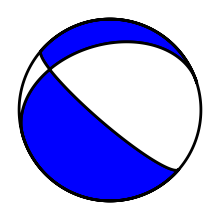

In [809]:
# see results
print('Best sdr: ', best_sdr)
print('Cosine similarity: ', -best_misfit)
print('Duration: ', duration)

# plot corresponding beachball
beachball = fr.beachball(best_sdr)

In [810]:
# compare best_sdr with Ao using R_pattern
As = fr.Rpattern(best_sdr, azimuth, takeoff_angles, [alpha, beta])

# get cosine similarity
cossim = fr.cossim(As, Ao)
if abs(cossim - 1) < 1e-5:
    print('Solution verified!')
else:
    print("Something's not right...")

Solution verified!


***
#### 3. Hierarchical grid search
***

In [813]:
# function definition
def hierarchical_grid_search(num_div, zoom_times, Ao, azimuth, takeoff_angles, alpha, beta) -> tuple:
    '''
    Implements hierarchical grid search as an inversion method.
    num_div: number of divisions in the first grid search
    zoom_times: number of times to zoom in on the best sdr
    '''
    
    # do a grid search in sdr space, make a of num_div**3 points
    # restrict to a hemisphere
    strike_range = linspace(0, 360, num_div)
    dip_range = linspace(0, 90, num_div)
    rake_range = linspace(-90, 90, num_div)
    
    # take note of windows
    strike_window = 2*pi / num_div
    dip_window = pi / (2*num_div)
    rake_window = pi / num_div
    
    counter = 0
    
    def mini_grid_search(counter):
        '''
        Implements a grid search in sdr space.
        '''
        # look for sdr that minimizes the misfit function
        best_sdr = zeros(3)
        best_misfit = inf
        
        # grid search in sdr space
        for strike in strike_range:
            for dip in dip_range:
                for rake in rake_range:
                    sdr = array([strike, dip, rake])
                    
                    # do forward model
                    As = fr.Rpattern(sdr, azimuth, takeoff_angles, [alpha, beta])
                    
                    # look at negative of cosine similarity
                    misfit = -fr.cossim(Ao, As)
                    
                    # update best_sdr if necessary
                    if misfit < best_misfit:
                        best_sdr = sdr
                        best_misfit = misfit
                    
                    counter += 1
        
        return best_sdr, best_misfit, counter
    
    while zoom_times > 0:
        # perform a grid search
        best_sdr, best_misfit, counter = mini_grid_search(counter)
        
        # zoom in on the best sdr
        strike_range = linspace(best_sdr[0] - strike_window/2, best_sdr[0] + strike_window/2, num_div)
        dip_range = linspace(best_sdr[1] - dip_window/2, best_sdr[1] + dip_window/2, num_div)
        rake_range = linspace(best_sdr[2] - rake_window/2, best_sdr[2] + rake_window/2, num_div)
        
        # update windows
        strike_window /= num_div
        dip_window /= num_div
        rake_window /= num_div
        zoom_times -= 1
    
    print(f'Solution found in {counter} iterations.')
    
    return best_sdr, best_misfit

In [840]:
# test and time the function
start_time = time()
# note that spacing is more important than zooming
best_sdr, best_misfit = hierarchical_grid_search(30, 4, Ao, azimuth, takeoff_angles, alpha, beta)
end_time = time()
duration = end_time - start_time

Solution found in 108000 iterations.


Best sdr:  [149.07384401  86.87127354 -34.19209442]
Cosine similarity:  0.9999979252124844
Duration:  3.2031564712524414


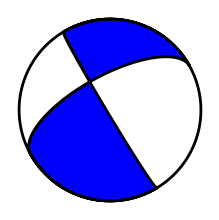

In [841]:
# see results
print('Best sdr: ', best_sdr)
print('Cosine similarity: ', -best_misfit)
print('Duration: ', duration)

# plot corresponding beachball
beachball = fr.beachball(best_sdr)

In [842]:
# compare best_sdr with Ao using R_pattern
As = fr.Rpattern(best_sdr, azimuth, takeoff_angles, [alpha, beta])

# get cosine similarity
cossim = fr.cossim(As, Ao)
if abs(cossim - 1) < 1e-5:
    print('Solution verified!')
else:
    print("Something's not right...")

Solution verified!
